In [1]:
import pyomo.environ as pyo

In [2]:
model = pyo.ConcreteModel()

# 변수 정의
model.x1 = pyo.Var(domain=pyo.NonNegativeReals)
model.x2 = pyo.Var(domain=pyo.NonNegativeReals)

# 목적함수 정의 (최대화)
model.obj = pyo.Objective(expr=3*model.x1 + 2*model.x2, sense=pyo.maximize)

# 제약조건 정의
model.con1 = pyo.Constraint(expr=2*model.x1 + model.x2 <= 100)
model.con2 = pyo.Constraint(expr=model.x1 + model.x2 <= 80)
model.con3 = pyo.Constraint(expr=model.x1 <= 40)

# ipopt 솔버로 모델을 풀기
solver = pyo.SolverFactory('ipopt')
result = solver.solve(model, tee=False)

# 결과 출력
print("x1 =", pyo.value(model.x1))
print("x2 =", pyo.value(model.x2))
print("목적함수 값 =", pyo.value(model.obj))


x1 = 20.000000200000173
x2 = 60.00000059749381
목적함수 값 = 180.00000179498812


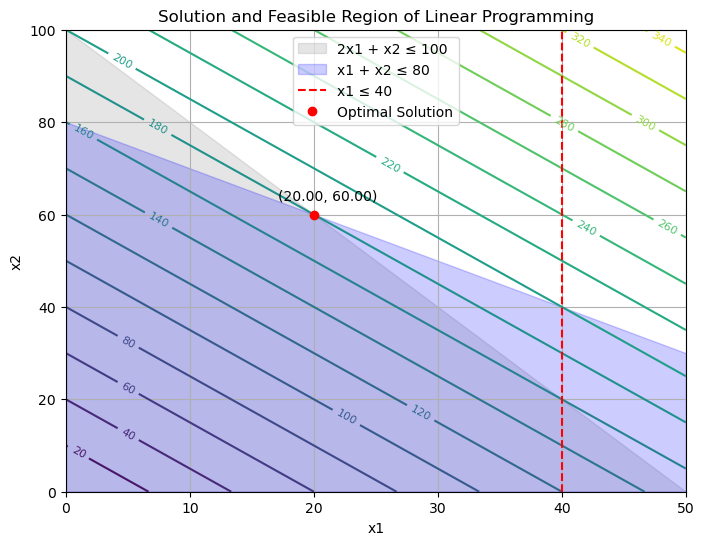

In [3]:
import matplotlib.pyplot as plt

# 변수 값
x1_val = pyo.value(model.x1)
x2_val = pyo.value(model.x2)

# 목적함수 등고선 그리기
import numpy as np

x1 = np.linspace(0, 50, 200)
x2 = np.linspace(0, 100, 200)
X1, X2 = np.meshgrid(x1, x2)
Z = 3*X1 + 2*X2

plt.figure(figsize=(8,6))
# 목적함수 등고선
contour = plt.contour(X1, X2, Z, levels=20, cmap='viridis')
plt.clabel(contour, inline=True, fontsize=8)

# 제약조건 영역 그리기
# 2x1 + x2 <= 100
plt.fill_between(x1, 0, 100-2*x1, color='gray', alpha=0.2, label='2x1 + x2 ≤ 100')
# x1 + x2 <= 80
plt.fill_between(x1, 0, 80-x1, color='blue', alpha=0.2, label='x1 + x2 ≤ 80')
# x1 <= 40
plt.axvline(40, color='red', linestyle='--', label='x1 ≤ 40')

# 음수 영역 제거
plt.xlim(0, 50)
plt.ylim(0, 100)

# 해 표시
plt.plot(x1_val, x2_val, 'ro', label='Optimal Solution')
plt.annotate(f'({x1_val:.2f}, {x2_val:.2f})', (x1_val, x2_val), textcoords="offset points", xytext=(10,10), ha='center')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Solution and Feasible Region of Linear Programming')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import pandas as pd
df = pd.read_csv('problem_3_network_dataset.csv')
df

,node_1,node_2,distance
0,1,2,20
1,1,4,8
2,2,3,15
3,2,6,22
4,2,7,7
5,2,12,6
6,3,16,19
7,4,8,26
8,4,11,20
9,6,24,29


In [5]:
import pyomo.environ as pyo

# 노드 리스트 생성
nodes = set(df['node_1']).union(set(df['node_2']))
arcs = list(zip(df['node_1'], df['node_2']))
dist_dict = {(row.node_1, row.node_2): row.distance for idx, row in df.iterrows()}

# 양방향 그래프이므로 반대 방향도 추가
for idx, row in df.iterrows():
    dist_dict[(row.node_2, row.node_1)] = row.distance
    arcs.append((row.node_2, row.node_1))
arcs = list(set(arcs))  # 중복 제거

model = pyo.ConcreteModel()
model.Arcs = pyo.Set(initialize=arcs, dimen=2)
model.Nodes = pyo.Set(initialize=nodes)

# 변수: arc (i,j)가 선택되면 1, 아니면 0
model.x = pyo.Var(model.Arcs, domain=pyo.Binary)

# 목적함수: 총 거리 최소화
def obj_rule(m):
    return sum(dist_dict[i, j] * m.x[i, j] for (i, j) in m.Arcs)
model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

# 흐름 제약식
def flow_rule(m, n):
    if n == 1:
        return sum(m.x[i, j] for (i, j) in m.Arcs if i == n) - sum(m.x[j, i] for (j, i) in m.Arcs if i == n) == 1
    elif n == 30:
        return sum(m.x[i, j] for (i, j) in m.Arcs if j == n) - sum(m.x[j, i] for (j, i) in m.Arcs if j == n) == 1
    else:
        return sum(m.x[i, j] for (i, j) in m.Arcs if i == n) - sum(m.x[j, i] for (j, i) in m.Arcs if i == n) == 0
model.flow = pyo.Constraint(model.Nodes, rule=flow_rule)

# MILP 풀기
solver = pyo.SolverFactory('ipopt')
result = solver.solve(model, tee=False)

# 결과 해석
if (result.solver.status == pyo.SolverStatus.ok) and (result.solver.termination_condition == pyo.TerminationCondition.optimal):
    print("최적해를 찾았습니다.")
    # 경로 추적
    path = [1]
    current = 1
    while current != 30:
        for (i, j) in model.Arcs:
            if i == current and pyo.value(model.x[i, j]) > 0.5:
                path.append(j)
                current = j
                break
    print("최단 경로:", path)
    print("최소 거리:", pyo.value(model.obj))
else:
    print("최적해를 찾지 못했습니다.")


source (type: set).  This WILL potentially lead to nondeterministic behavior
in Pyomo
최적해를 찾았습니다.
최단 경로: [1, 2, 3, 16, 26, 30]
최소 거리: 117.999974736684
